In [1]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth

dry = True

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [44]:
from scipy import stats

def mergeMethods(bis_df, nano_df):
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd", "modification_type"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth", "method"], i=["chromosome", "chromStart", "chromEnd", "modification_type"], 
                                  j="Method", sep="_", suffix="\D+")
    return wide_merged.reset_index(), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)



In [54]:
stats.cramervonmises_2samp(two_mod_wide["percentMeth_Nanopore"], two_mod_wide["percentMeth_Bisulphite"], method="asymptotic")

CramerVonMisesResult(statistic=1443.3690967346483, pvalue=2.6002318120887935e-07)

/tmp/ipykernel_298458/1075486247.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax4)
/tmp/ipykernel_298458/1075486247.py:63: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax5)
/tmp/ipykernel_298458/1075486247.py:71: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax6)


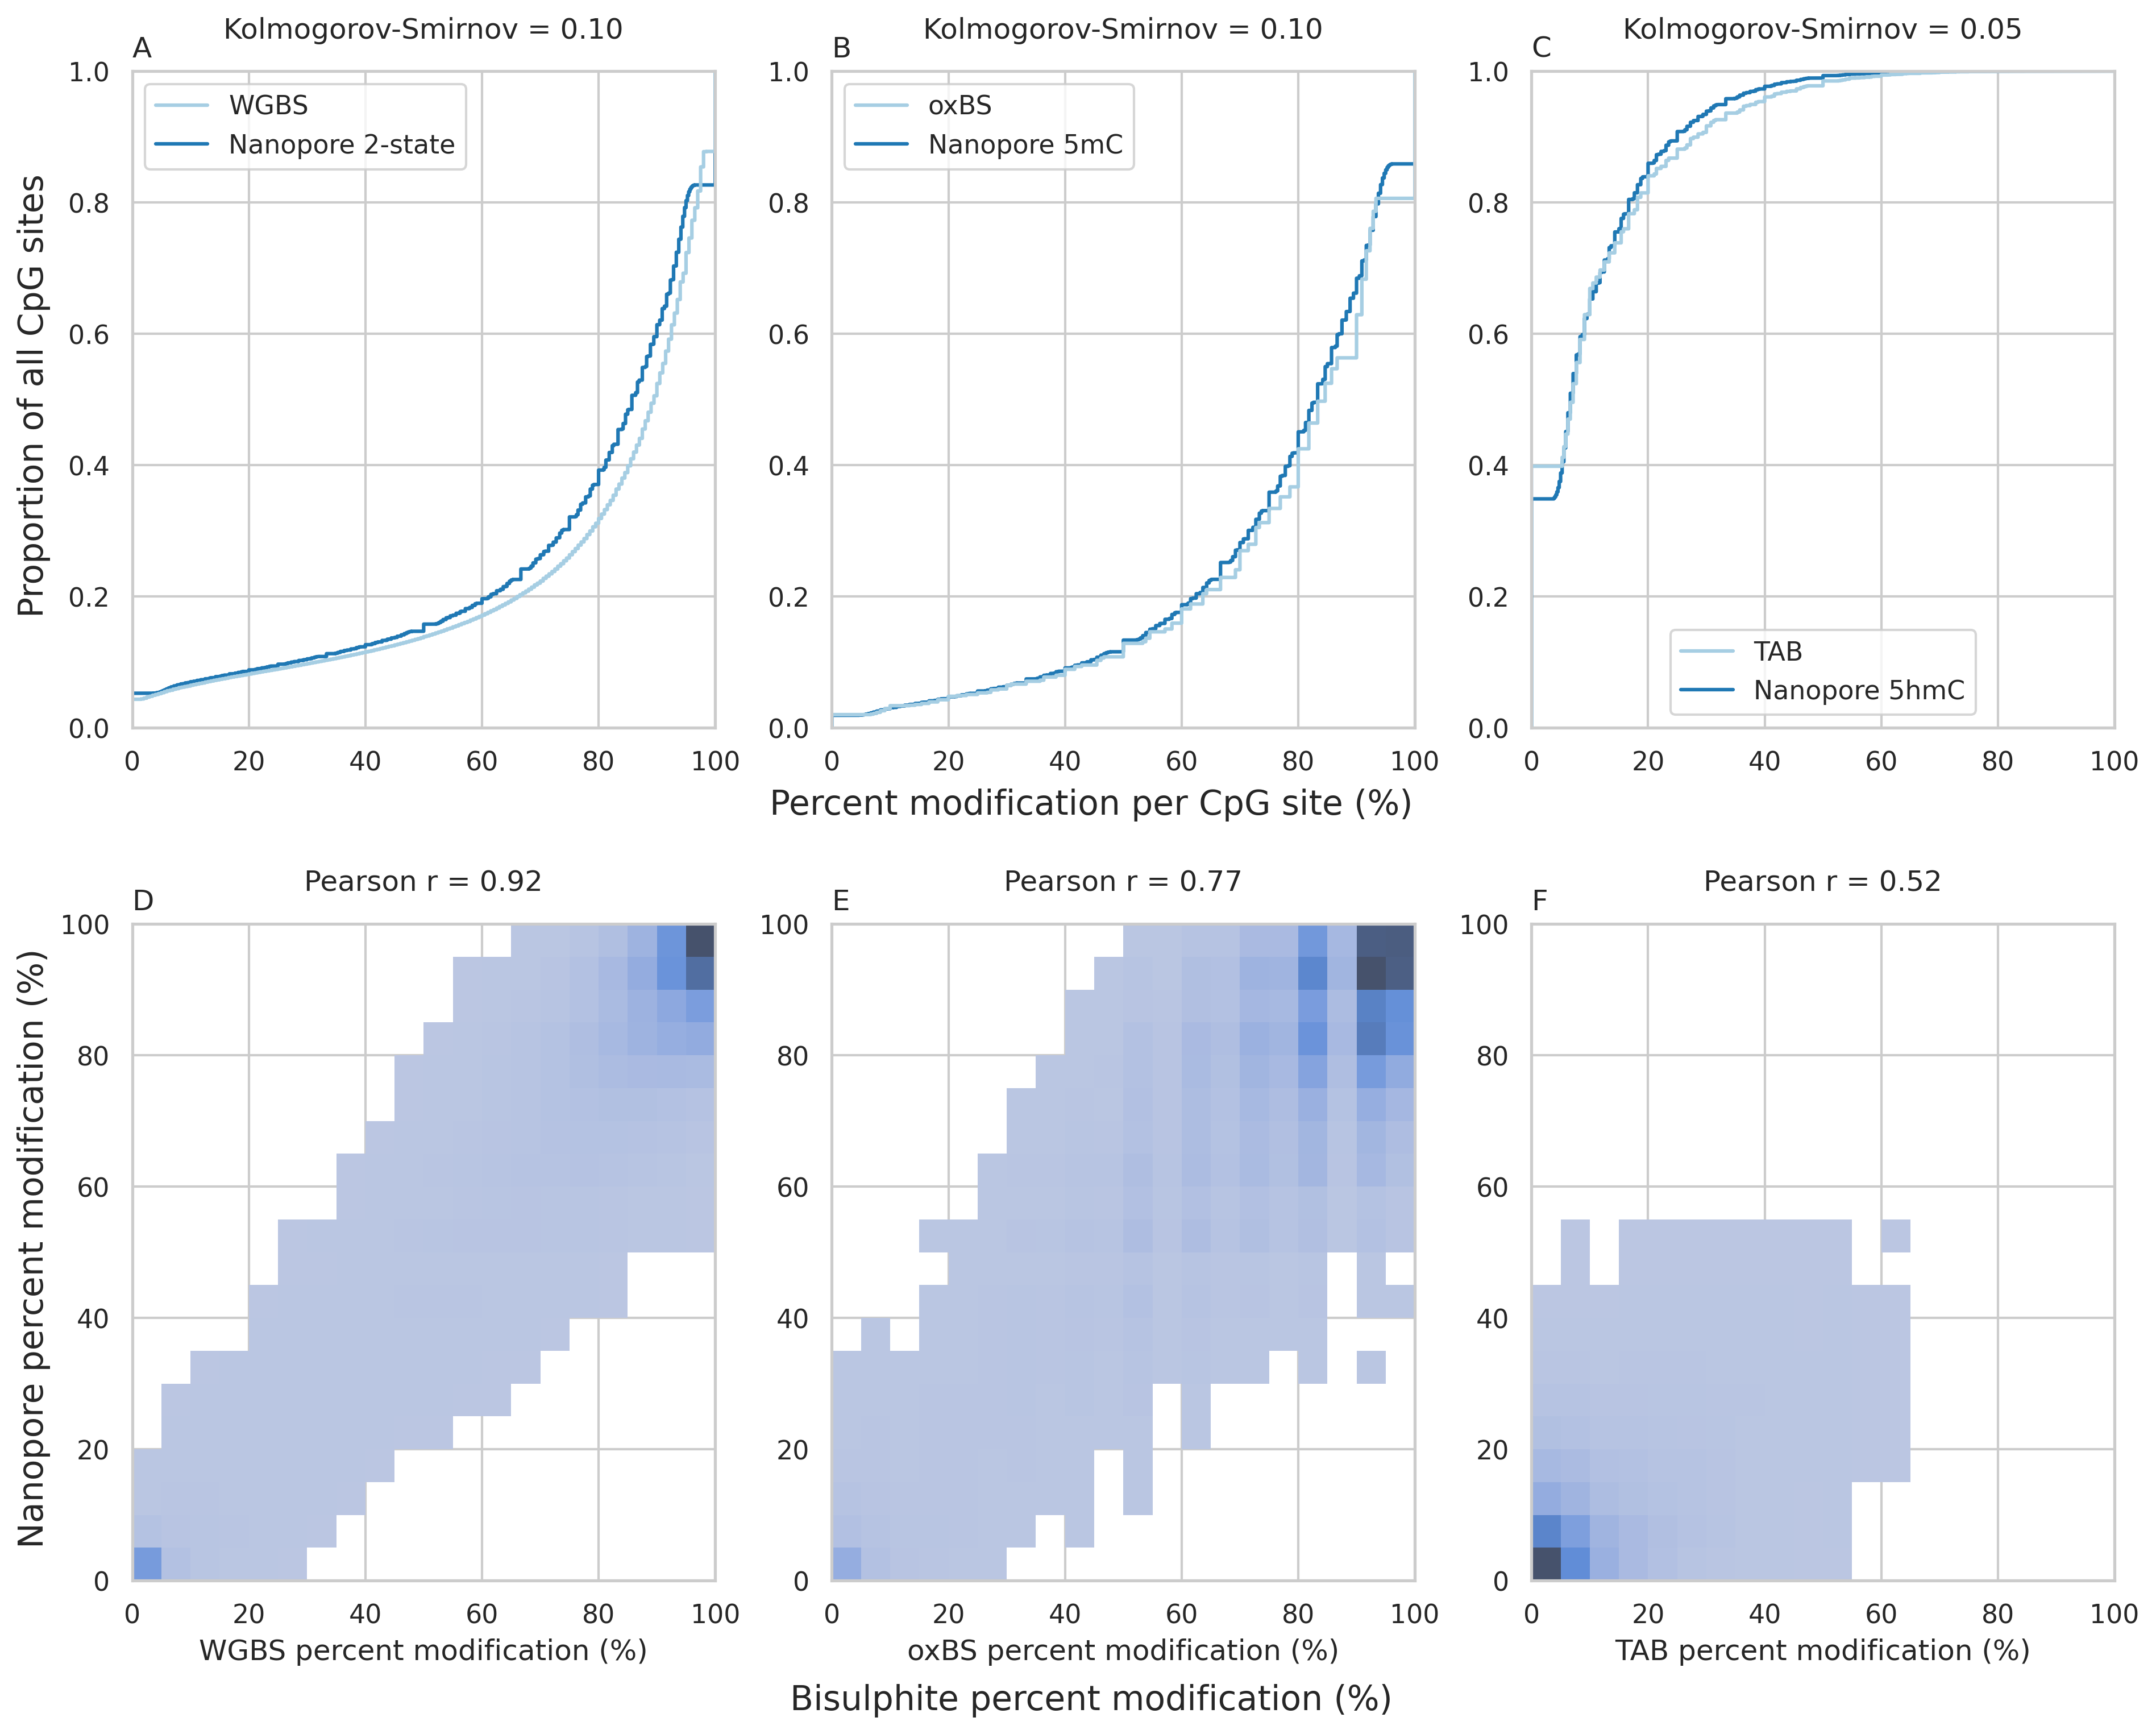

In [46]:
import seaborn as sns
import matplotlib.pyplot as pl
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")

fig = pl.figure(dpi=300, figsize=(15, 10)) 
gs = GridSpec(2, 1, fig)

fig1 = fig.add_subfigure(gs[0, :])
gs1 = GridSpec(1, 3, fig1)
fig1.supxlabel("Percent modification per CpG site (%)", y=0)
fig1.supylabel("Proportion of all CpG sites", x=0.08)

ax1 = fig1.add_subplot(gs1[0, 0])
ax2 = fig1.add_subplot(gs1[0, 1])
ax3 = fig1.add_subplot(gs1[0, 2])

two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax1)
sns.move_legend(ax1, "upper left", title=None)
# ax1.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.set_title("A", loc="left")
ax1.set_xlim([0, 100])

mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax2)
sns.move_legend(ax2, "upper left", title=None)
# ax2.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_title("B", loc="left")
ax2.set_xlim([0, 100])

hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax3)
sns.move_legend(ax3, "lower center", title=None)
# ax3.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_xlim([0, 100])
ax3.set_title("C", loc="left")

fig2 = fig.add_subfigure(gs[1, :])
fig2.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig2.supylabel("Nanopore percent modification (%)", x=0.08)
gs2 = GridSpec(1, 3, fig2)

ax4 = fig2.add_subplot(gs2[0, 0])
ax5 = fig2.add_subplot(gs2[0, 1])
ax6 = fig2.add_subplot(gs2[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax4)
ax4.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax4.set_xlim((0, 100))
ax4.set_ylim((0, 100))
ax4.set_xlabel("WGBS percent modification (%)")
ax4.set_ylabel(None)
ax4.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax5)
ax5.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax5.set_xlim((0, 100))
ax5.set_ylim((0, 100))
ax5.set_xlabel("oxBS percent modification (%)")
ax5.set_ylabel(None)
ax5.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", palette="crest", ax=ax6)
ax6.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax6.set_xlim((0, 100))
ax6.set_ylim((0, 100))
ax6.set_xlabel("TAB percent modification (%)")
ax6.set_ylabel(None)
ax6.set_title("F", loc="left")

fig.show()